In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from tqdm.notebook import tqdm
import scraping_class
from webdriver_manager.chrome import ChromeDriverManager
import requests
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.metrics import mean_squared_error as mse

# Section X: Modelling

## Exploring our Data

In section XX we cleaned our data and it is now ready to preprocess in order to use it for modelling. The cleaned data looks like the following: 

In [2]:
df_cleaned = pd.read_csv('merged_data.csv', index_col=0)
print('No. of rows and columns:', df_cleaned.shape)
df_cleaned.head()

No. of rows and columns: (7895, 19)


,name,rating,sub_region,year,price_DKK,total_ratings,total_reviews,light-bold,smooth-tannic,dry-sweet,soft-acidic,winery,light-bold-cat,smooth-tannic-cat,dry-sweet-cat,soft-acidic-cat,region,cardinal_1,cardinal_2
0,Passivento Rosso,3.6,Terre Siciliane,2019,93.17,96,1103,0.744740,0.330456,0.442528,0.210002,Barone Montalto,bold,semi smooth,sweet,soft,Sicilia,South,South
1,Pillastro Primitivo Puglia,4.0,Puglia,2019,69.00,823,2072,0.654435,0.154071,0.387081,0.066322,Cantine due Palme,semi bold,smooth,semi sweet,soft,Puglia,East,South-east
2,Fantini Sangiovese Terre di Chieti,3.6,Terre di Chieti,2019,84.17,70,1001,0.424077,0.328759,0.065716,0.403993,Farnese,semi light,semi smooth,dry,semi soft,Abruzzo,East,East
3,Appassite Negroamaro - Primitivo,4.0,Puglia,2019,89.17,102,800,0.825000,0.334615,0.349416,0.184099,Luna Argenta,bold,semi smooth,semi sweet,soft,Puglia,East,South-east
4,Passivento Rosso,3.6,Terre Siciliane,2019,93.17,97,1103,0.744727,0.330469,0.442570,0.210016,Barone Montalto,bold,semi smooth,sweet,soft,Sicilia,South,South


### Converting Columns into Dummy Variables

As we have some categorical variables in our dataset, we want to turn these into dummy variables containing binary values 0 or 1. 

In [3]:
dummies = pd.get_dummies(df_cleaned, columns=['region'], drop_first=True) # Using drop_first to avoid The Dummy Variable Trap
df_dummies = pd.concat([df_cleaned, dummies], axis=1)
df_dummies.drop(['name', 'sub_region', 'region', 'total_ratings', 'total_reviews', 'winery', 'light-bold-cat', 
                 'smooth-tannic-cat', 'dry-sweet-cat', 'soft-acidic-cat', 'cardinal_1', 'cardinal_2'], 
                 inplace=True, axis=1)
df_dummies = df_dummies.iloc[:, 7:] # Drop duplicated columns
df_dummies.head()

,rating,year,price_DKK,light-bold,smooth-tannic,dry-sweet,soft-acidic,region_Basilicata,region_Calabria,region_Campania,...,region_Molise,region_Piemonte,region_Puglia,region_Sardegna,region_Sicilia,region_Toscana,region_Trentino-Alto Adige,region_Umbria,region_Valle d’Aosta,region_Veneto
0,3.6,2019,93.17,0.744740,0.330456,0.442528,0.210002,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,4.0,2019,69.00,0.654435,0.154071,0.387081,0.066322,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3.6,2019,84.17,0.424077,0.328759,0.065716,0.403993,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2019,89.17,0.825000,0.334615,0.349416,0.184099,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,3.6,2019,93.17,0.744727,0.330469,0.442570,0.210016,0,0,0,...,0,0,0,0,1,0,0,0,0,0


We now have a dataset containing only numeric data although we have included the categorical data, which is great. We see that the region 'Abruzzo' was made the reference for the dummy variables. 

### Statistical Information

To get started we run a simple description function to get a sense of the statistic information of the dataset: 

In [4]:
df_dummies.describe()

,rating,year,price_DKK,light-bold,smooth-tannic,dry-sweet,soft-acidic,region_Basilicata,region_Calabria,region_Campania,...,region_Molise,region_Piemonte,region_Puglia,region_Sardegna,region_Sicilia,region_Toscana,region_Trentino-Alto Adige,region_Umbria,region_Valle d’Aosta,region_Veneto
count,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,...,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000
mean,4.194820,2010.545028,840.799951,0.585282,0.462164,0.152078,0.486437,0.003927,0.003040,0.010133,...,0.001267,0.248385,0.068904,0.011653,0.036732,0.383281,0.001267,0.008993,0.000507,0.182774
std,0.358069,6.929609,1438.943777,0.133882,0.182015,0.153446,0.224509,0.062543,0.055055,0.100158,...,0.035569,0.432104,0.253307,0.107325,0.188115,0.486217,0.035569,0.094410,0.022505,0.386506
min,2.800000,1917.000000,11.750000,0.231590,0.085450,0.000000,0.008667,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.900000,2008.000000,159.975000,0.474412,0.340428,0.040919,0.255695,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.300000,2012.000000,375.000000,0.588094,0.419206,0.084284,0.474183,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.500000,2015.000000,826.080000,0.646981,0.584629,0.231508,0.628518,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,4.900000,2019.000000,23050.680000,0.825000,0.825000,0.586491,0.825000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In the above table we see that we have a total of XXXX rows in the dataset and hence XXXX observations. We start by looking at one column at a time. 

In the '*rating*' column we see that the mean rating is ~4.16 with a standard deviation of ~0.38. This is a fairly high average rating. We also see that the 1st quantile is 3.9 and we can conclude that most wines in the Vivino.com network has a high rating. 

For the '*year*' column we see that the years of the wine is spread from 1917 up until 2019. However, as the mean year is around 2011, we might have to check whether there are som outliers that a worth removing from our dataset before we begin modelling. 

In the '*price, kr.*' column we inspect the prices of the wines. Here we see that the prices span from just 11 kr. to 11.500. As the mean is ~466 kr. and the standard deviation is ~821, the minimum value seems resonible (although that's a very cheap red wine, **more on that in the discussion of the data quality later**), but the maximum value of 11.500 kr. seems like an outlier and we will have to check whether some of these high prices should be removed. 

For the next four columns with the taste characteristics we see that all values span from 0% to 82.5%. This was expected as the numbers represent percentages, however there seems to be a static upper cap on the maximum values. Inspecting the Vivino.com site we see that it looks like there is indeed a maximum cap of how high the percentages can get (**more on that in the discussion of the data quality later**). 

The rest of the columns are our region dummy variables and hence are binary values. As such, these descriptive measures are not of our interest. 

### Inspecting Correlations

Next we examine the correlation between the variables in order to get a better understanding of the relationships between them. We check to see which features are more correlated with the target variable as the model will producere a more accurate result if we pass significant features to the model.

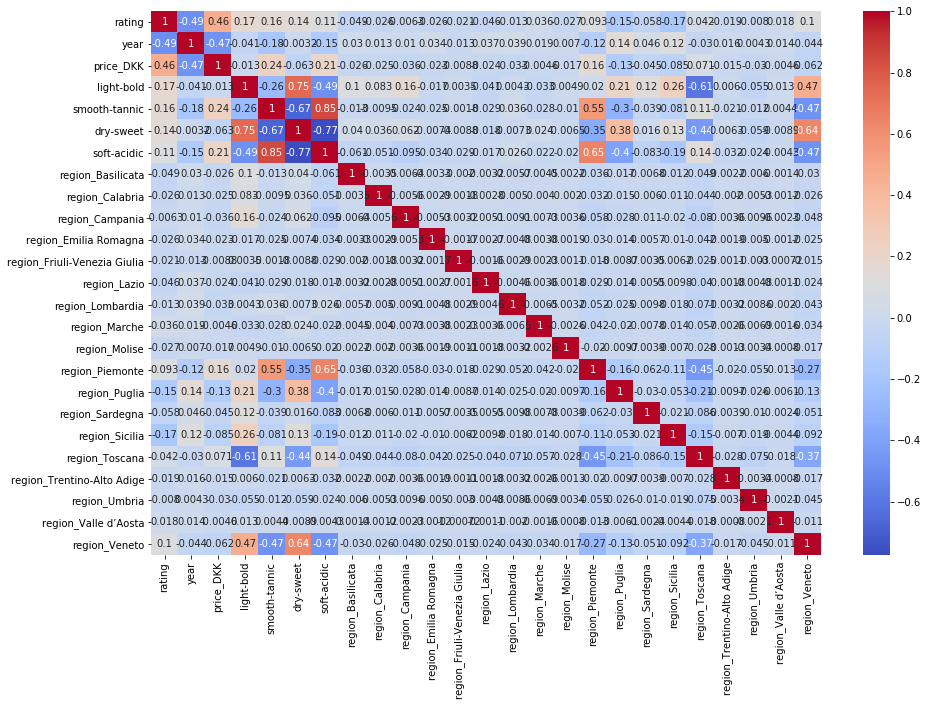

In [5]:
plt.subplots(figsize=(15, 10))
sns.heatmap(df_dummies.corr(), annot=True, cmap='coolwarm')

We see that some features are much more correlated with the target variable than others. Especially the '*year*' and '*price, kr.*' columns are highly correlated with the '*rating*' variable and are therefore important features to include in the model. 

If we look at the correlations between the input variables, we see that there are examples of relationships with high correlations. The highest of these is the correlation between '*soft-acidic*' and '*smooth-tannic*'. Intuitively, this makes sense as a higher acidity often gives a more tannic wine. **Is this true ???**

These correlation values might be interesting to look at when possibly reducing the number of features in the model. 

### Detecting Outliers

In order to detect possible outliers in our dataset, we start by making boxplots of the different variables in order to get a better insight of the distribution of the values in the columns. For this we exclude our dummy variables. 

Text(0.5, 0, '')

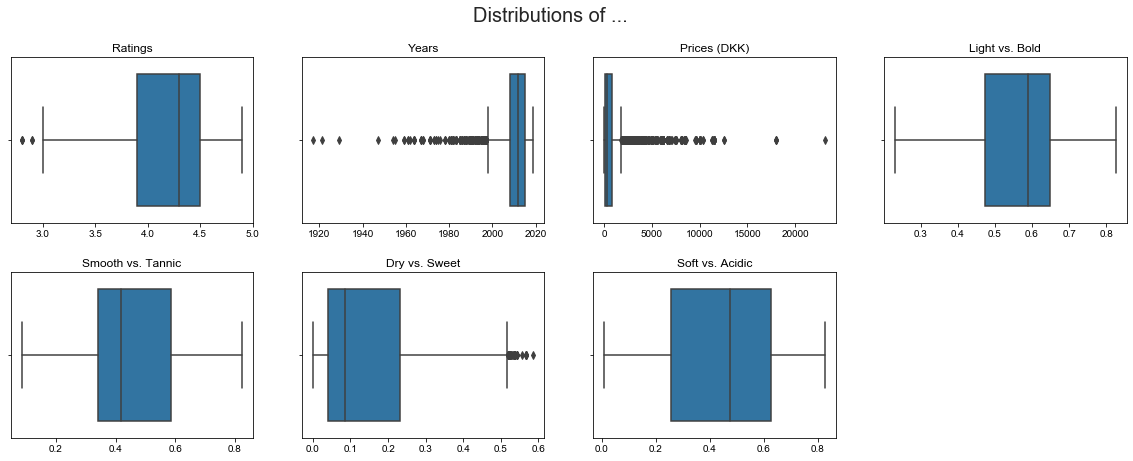

In [6]:
fig, ax = plt.subplots(2, 4, figsize=(20,7))
fig.delaxes(ax[1][3])
fig.subplots_adjust(hspace=0.3) # Adding space between rows
sns.set_style("whitegrid")
fig.suptitle('Distributions of ...', fontsize=20)

bp1 = sns.boxplot(df_dummies['rating'], ax=ax[0][0])
bp2 = sns.boxplot(df_dummies['year'], ax=ax[0][1])
bp3 = sns.boxplot(df_dummies['price_DKK'], ax=ax[0][2])
bp6 = sns.boxplot(df_dummies['light-bold'], ax=ax[0][3])
bp7 = sns.boxplot(df_dummies['smooth-tannic'], ax=ax[1][0])
bp8 = sns.boxplot(df_dummies['dry-sweet'], ax=ax[1][1])
bp9 = sns.boxplot(df_dummies['soft-acidic'], ax=ax[1][2])

ax[0][0].set_title('Ratings')
ax[0][1].set_title('Years')
ax[0][2].set_title('Prices (DKK)')
ax[0][3].set_title('Light vs. Bold')
ax[1][0].set_title('Smooth vs. Tannic')
ax[1][1].set_title('Dry vs. Sweet')
ax[1][2].set_title('Soft vs. Acidic')

ax[0][0].set_xlabel('')
ax[0][1].set_xlabel('')
ax[0][2].set_xlabel('')
ax[0][3].set_xlabel('')
ax[1][0].set_xlabel('')
ax[1][1].set_xlabel('')
ax[1][2].set_xlabel('')

From the above we see that most of the values are evenly spread for the different variables. However, the '*year*' and '*price_DKK*' variables have a lot of outliers in the left and right part of the boxplots respectively. We see that most of the wines are produced between 1995 and 2019 at a price levet from 0 kr. to ~2000 kr. The values outside these limits seem to be outliers. 

In order to streamline the data and get the best performance of the machine learning model, we want to remove these outliers. At first we examine how many outliers we have in order to check whether it is wise to remove them. 

In [7]:
print('There are', len(df_dummies), 'observations in total.')
print()
print('There are', np.count_nonzero(df_dummies['year']<1995), 'observations before year 1995, which corresponds to',
     round(np.count_nonzero(df_dummies['year']<1995)/len(df_dummies)*100,1), '% of the data.')
print()
print('There are', np.count_nonzero(df_dummies['price_DKK']>2000), 'observations with a price above 2000 kr., which corresponds to',
     round(np.count_nonzero(df_dummies['price_DKK']>2000)/len(df_dummies)*100,1), '% of the data.')
print()
print('There are', np.count_nonzero(np.logical_or(df_dummies['year']<1995, df_dummies['price_DKK']>2000)), 'observations before year 1995 OR with a price above 2000 kr., which corresponds to',
     round(np.count_nonzero(np.logical_or(df_dummies['year']<1995, df_dummies['price_DKK']>2000))/len(df_dummies)*100,1), '% of the data.')

There are 7895 observations in total.

There are 205 observations before year 1995, which corresponds to 2.6 % of the data.

There are 795 observations with a price above 2000 kr., which corresponds to 10.1 % of the data.

There are 892 observations before year 1995 OR with a price above 2000 kr., which corresponds to 11.3 % of the data.


From the above we see that removing the outliers in columns '*year*' and '*price, kr.*' will only remove 8.6% of our observations and as so we remove them. We now use the *z*-score in order to correctly find and remove the true outliers. To find the *z*-scores we take each observation value, subtract the mean and divide this by the standard deviation. As such, the score tells us how many standard deviations the observation value is from the mean. Mathematically the *z*-score is defined as follows: 
\begin{align}
z = \frac{X-\mu}{\sigma} \\
\end{align}

We calculate the *z*-score for each observation and characterise an observation as an outlier if the *z*-score of that observation is greater than 3 or less than -3. Using the number 3 as threshold is based on the empirical rule. 

**Kilder**: 

https://en.wikipedia.org/wiki/Standard_score 

https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule 

In [8]:
# Outliers in the 'price, kr.' column
threshold = 3
outliers_price = [] 
mean_price = df_dummies['price_DKK'].values.mean()
std_price = df_dummies['price_DKK'].values.std() 
for x in df_dummies['price_DKK'].values:
    z = (x-mean_price)/std_price
    if abs(z) > threshold: 
        outliers_price.append(x) 
outliers_price = sorted(outliers_price)
print('The outliers in the "price_DKK" column are:', outliers_price, '\nNumber of outliers:', 
      len(outliers_price), '\nPart of dataset:', round(len(outliers_price)/len(df_dummies)*100, 1), '%')

The outliers in the "price_DKK" column are: [5165.2, 5165.2, 5165.2, 5165.2, 5165.2, 5165.2, 5165.2, 5165.2, 5165.2, 5165.2, 5165.2, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5495.0, 5495.0, 5495.0, 5495.0, 5495.0, 5495.0, 5495.0, 5495.0, 5495.0, 5495.0, 5495.0, 5495.0, 5500.0, 5623.66, 5888.67, 5920.92, 5981.12, 5981.12, 5993.71, 5993.71, 5995.0, 5995.0, 5995.0, 5995.0, 5995.0, 6013.22, 6013.22, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6629.22, 6629.22, 6629.22, 6828.09, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 7058.25, 7080.94, 744

In [9]:
# Outliers in the 'year' column
threshold = 3
outliers_year = [] 
mean_year = df_dummies['year'].values.mean()
std_year = df_dummies['year'].values.std() 
for x in df_dummies['year'].values:
    z = (x-mean_year)/std_year
    if abs(z) > threshold: 
        outliers_year.append(x) 
outliers_year = sorted(outliers_year)
print('The outliers in the "year" column are:', outliers_year, '\nNumber of outliers:', len(outliers_year),
     '\nPart of dataset:', round(len(outliers_year)/len(df_dummies)*100, 1), '%')

The outliers in the "year" column are: [1917, 1921, 1929, 1947, 1954, 1955, 1959, 1959, 1961, 1961, 1962, 1964, 1964, 1964, 1964, 1967, 1967, 1967, 1968, 1968, 1971, 1971, 1971, 1971, 1973, 1973, 1974, 1974, 1975, 1976, 1978, 1978, 1978, 1980, 1980, 1981, 1981, 1981, 1981, 1981, 1981, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1983, 1983, 1983, 1983, 1983, 1983, 1983, 1983, 1985, 1985, 1985, 1985, 1985, 1985, 1985, 1985, 1985, 1985, 1985, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1987, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989] 
Number of outliers: 113 
Part of dataset: 1.4 %


As we see from the above calculations, we were a bit harsh on the range of outliers as we now "only" have 202 and 113 outliers for price and year respectively. We will now remove these outliers from out dataset. 

In [10]:
df_ready = df_dummies.copy()
df_ready = df_ready[~df_ready['price_DKK'].isin(outliers_price)] # Removing price outliers
df_ready = df_ready[~df_ready['year'].isin(outliers_year)] # Removing year outliers

In [12]:
print('Year:', '\n', '\nMean before:', df_dummies['year'].mean(), '\nMean after:', df_ready['year'].mean(),
      '\nDifference:', round((df_ready['year'].mean()-df_dummies['year'].mean())/df_dummies['year'].mean()*100,3), '%\n',
      '\nStd. before:', df_dummies['year'].std(), '\nStd. after:', df_ready['year'].std(), '\nDifference:',
      round((df_ready['year'].std()-df_dummies['year'].std())/df_dummies['year'].std()*100,3), '%\n')
print()
print('Price:', '\n', '\nMean before:', df_dummies['price_DKK'].mean(), '\nMean after:', df_ready['price_DKK'].mean(),
      '\nDifference:', round((df_ready['price_DKK'].mean()-df_dummies['price_DKK'].mean())/df_dummies['price_DKK'].mean()*100,3), '%\n',
      '\nStd. before:', df_dummies['price_DKK'].std(), '\nStd. after:', df_ready['price_DKK'].std(), '\nDifference:',
      round((df_ready['price_DKK'].std()-df_dummies['price_DKK'].std())/df_dummies['price_DKK'].std()*100,3), '%\n')

Year: 
 
Mean before: 2010.54502849905 
Mean after: 2011.224934383202 
Difference: 0.034 %
 
Std. before: 6.929608636214551 
Std. after: 5.372835947603216 
Difference: -22.466 %


Price: 
 
Mean before: 840.7999506016528 
Mean after: 651.0448333333358 
Difference: -22.568 %
 
Std. before: 1438.9437772554888 
Std. after: 807.180452933326 
Difference: -43.905 %



As we can see from the above, the means of the '*year*' column hasn't changed much. This is probably due to the fact that the numerical values of the years aren't that far away from each other. However, removing the outliers decreases the standard deviation with 22%. 

Removing the outliers for the '*price, kr.*' column decreases the mean with 23% due to the high prices being removed. But again we see that the standard deviation has improved a lot as it has decreased by 44%. 

We conclude that removing those few outliers (a decrease in the number of rows of 3.5%) improves our data quality and possibly affect the performance of our machine learning model positively. 

To take a look at this new (and hopefully improved) data, we check the difference in the correlations between the target variable and the input variables. 

In [13]:
correlation_overview = pd.DataFrame({'before':df_dummies.corrwith(df_dummies['rating']), 
                                     'after':df_ready.corrwith(df_ready['rating']), 
                                    '%-diff':round((df_ready.corrwith(df_ready['rating'])-df_dummies.corrwith(df_dummies['rating']))/df_dummies.corrwith(df_dummies['rating']), 2)})
correlation_overview


,before,after,%-diff
rating,1.000000,1.000000,0.00
year,-0.494027,-0.526604,0.07
price_DKK,0.463180,0.562766,0.22
light-bold,0.173684,0.180481,0.04
smooth-tannic,0.158887,0.144250,-0.09
dry-sweet,0.141192,0.150257,0.06
soft-acidic,0.106363,0.092145,-0.13
region_Basilicata,-0.049436,-0.048126,-0.03
region_Calabria,-0.026190,-0.024541,-0.06
region_Campania,-0.006307,-0.002089,-0.67


We see that the two highly correlated variables '*year*' and '*price_DKK*' are now even more correlated with the target variable. The remaining input variables are either approximately the same or have decreased. In most cases the decrease has in fact decreased the correlation as the correlations approaches zero. 

## Applying Supervised Machine Learning

Process: 

1) Short description of the use of ML and the dangers of over- and underfitting (see Frisks)

2) Splitting data in X and y

3) Describe the use of cross validation and K-folds

4) Explain why we split data in folds, development/test and use Grid Search (when searching for optimal hyperparameters)

5) Explain why we use the pipeline (E.g. what does the StandardScaler do? Why do we use PolynomialFeatures?) 

6) Describe the different models (OLS, Ridge, Lasso, Elastic Net) (Gradient Descent? Perceptron?)

7) Declare hyperparameters to tune in the different models

8) Fit, optimise and evaluate: OLS 

9) Fit, optimise and evaluate: Ridge

10) Fit, optimise and evaluate: Lasso

11) Fit, optimise and evaluate: Elastic Net

12) Compare RMSE/MSE calculated using test data and choose the optimal model

13) Discuss feature reduction

14) Try fitting a model with taste notes as the only input variables

https://www.analyticsvidhya.com/blog/2015/08/comprehensive-guide-regression/

https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn#step-4

In [14]:
# Splitting the data in target and data (y and x)
y = df_ready.rating.to_numpy()
X = df_ready.drop(['rating'],axis=1) 

In [15]:
# Split X, y into development and test data 
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=.3, random_state=1)    

In [16]:
# Defining a function to calculate RMSE 
def rmse(y_pred, y_true):
    return mse(y_pred, y_true, squared=False)

**SHOULD WE INCLUDE BIAS OR NOT?**

**CHANGE FROM SERIES TO DATAFRAME WHEN SAVING THE OPTIMAL VALUES**

**DO WE USE THE MEASURES MADE ON TRAIN FOR ANYTHING? OR DO WE ONLY NEED TO SAVE RMSE/MSE FOR TEST DATA?**

**CAN WE PRINT THE COEFFICIENTS FROM THE LINEAR REGRESSION?**

**CAN WE MAKE ANY PLOTS? E.G. OF LAMBDA VALUES OR RMSE/MSE**

#### Linear Regression

For the Linear Regression model we don't have any hyperparameters to optimise, and so we use the training and development sets to decide whether or not to add polynomials. We split the development data into training and validation sets in a 50%/50% split. 

We know from prior knowledge that the usual peak of performance occurs at either 2nd or 3rd degree. Due to attempts to increase the degree even further where we lack in computational power, we have decided to only test the different models up to and including 4th degree. 

In [214]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.5, random_state=1)

In [221]:
# Linear Regression with Polynomials
lambdas =  np.logspace(-4, 4, 20)

lr_mse_train = []
lr_rmse_train = []
lr_mse_val = []
lr_rmse_val = []
lr_coefs_val = []
lr_inter_val = []

for i in tqdm(range(1, 5)): 
    pipe_lr_pol = make_pipeline(PolynomialFeatures(degree=i, include_bias=True),
                                StandardScaler(),
                                LinearRegression())
    pipe_lr_pol.fit(X_train, y_train)
    
    lr_mse_train.append(mse(pipe_lr_pol.predict(X_train),y_train))
    lr_rmse_train.append(rmse(pipe_lr_pol.predict(X_train),y_train))
    lr_mse_val.append(mse(pipe_lr_pol.predict(X_val),y_val))
    lr_rmse_val.append(rmse(pipe_lr_pol.predict(X_val),y_val))
    lr_coefs.append(pipe_lr.steps[1][1].coef_)
    lr_inter.append(pipe_lr.steps[1][1].intercept_)
    

In [229]:
lr_overview = pd.DataFrame({'MSE train':lr_mse_train, 'RMSE train':lr_rmse_train, 'MSE val':lr_mse_val, 'RMSE val':lr_rmse_val}
                           , index=range(1,5))
lr_overview

,MSE train,RMSE train,MSE val,RMSE val
1,0.056454,0.237601,6.410091e-02,2.531816e-01
2,0.037398,0.193385,5.607857e+24,2.368091e+12
3,0.030437,0.174461,9.340926e+24,3.056293e+12
4,0.016984,0.130322,1.378094e+19,3.712269e+09


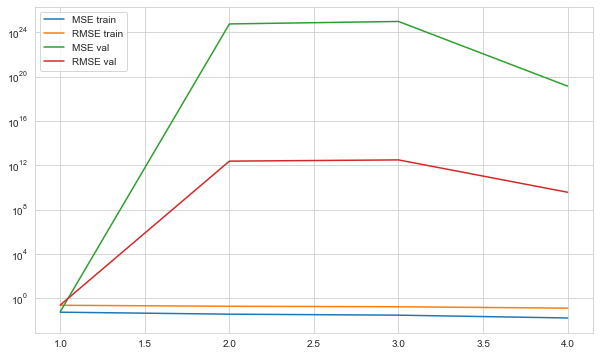

In [232]:
lr_overview.plot(logx=False, logy=True, figsize=(10,6))

The index represents each degree. From the above results we see that the MSE and RMSE for the training data decreases with the number of degrees. Adding polynomials hence increases the accuracy in which the fit describes the traning data. However, the MSE and RMSE for the validation data drastically increases when we add more polynomials and so the fit doesn't fit new data very well. This is a classic example of overfitting. 
We conclude that adding polynomials to an OLS model does not improve the accuracy of the fit and that the simple linear regression is the best model of this type.

#### Ridge Regression

When attempting to optimise a Ridge Regression on our data and find the optimal degree and hyperparameter, we tried using GridSearchCV to automate the process. However as you can see below, there were too many combinations of hyperparameter values and degree values and it took more than 12 hours to run the search from 1st to 4th degree. Also, we can see from the first four results below that the MSE/RMSE did indeed increase from the 3rd to the 4th degree. 

In [207]:
# Ridge Regression with polynomials
lambdas =  np.logspace(-4, 4, 20)

ridge_mse = []
ridge_rmse = []

for i in tqdm(range(1, 5)): 
    pipe_ridge_pol = make_pipeline(PolynomialFeatures(degree=i, include_bias=True),                           
                                   StandardScaler(),
                                   Ridge(random_state=1))

    ridge_pol_regr = GridSearchCV(estimator=pipe_ridge_pol, 
                                  param_grid=[{'ridge__alpha':lambdas}], 
                                  scoring='neg_mean_squared_error', 
                                  cv=10, 
                                  n_jobs=-1)
    ridge_pol_regr.fit(X_dev, y_dev)
    
    ridge_mse.append(ridge_pol_regr.best_score_*-1)
    ridge_rmse.append(np.sqrt(ridge_pol_regr.best_score_*-1))
    
    print(f'Degree={i}', '\nBest parameters:', ridge_pol_regr.best_params_, 
          '\nBest score (MSE):', ridge_pol_regr.best_score_*-1, 
          '\nBest score (RMSE):', np.sqrt(ridge_pol_regr.best_score_*-1))
    print()
    

Degree=1 
Best parameters: {'ridge__alpha': 11.288378916846883} 
Best score (MSE): 0.06058823334785286 
Best score (RMSE): 0.24614677196309698

Degree=2 
Best parameters: {'ridge__alpha': 11.288378916846883} 
Best score (MSE): 0.04780514382959335 
Best score (RMSE): 0.21864387443876251

Degree=3 
Best parameters: {'ridge__alpha': 206.913808111479} 
Best score (MSE): 0.04777620551587649 
Best score (RMSE): 0.21857768759842916

Degree=4 
Best parameters: {'ridge__alpha': 1438.44988828766} 
Best score (MSE): 0.05184769215433258 
Best score (RMSE): 0.22770088307763012



KeyboardInterrupt: 

As such, we try to use RandomizedSearchCV instead, which hopefully doesn't take as long time to finish. 

In [236]:
# Ridge Regression with Polynomials (Randomized Search)
lambdas =  np.logspace(-4, 4, 20)

ridge_mse = []
ridge_rmse = []
ridge_best_param = []

for i in tqdm(range(1, 5)): 
    pipe_ridge_pol = make_pipeline(PolynomialFeatures(degree=i, include_bias=True),                           
                                   StandardScaler(),
                                   Ridge(random_state=1))

    ridge_pol_regr_rand = RandomizedSearchCV(estimator=pipe_ridge_pol, 
                                             param_distributions=[{'ridge__alpha':lambdas}], 
                                             scoring='neg_mean_squared_error', 
                                             cv=10, 
                                             n_jobs=-1)
    ridge_pol_regr_rand.fit(X_dev, y_dev)
    
    ridge_mse.append(ridge_pol_regr_rand.best_score_*-1)
    ridge_rmse.append(np.sqrt(ridge_pol_regr_rand.best_score_*-1))
    ridge_best_param.append(ridge_pol_regr_rand.best_params_)


Below we summarize which hyperparameter value is best for each degree as well as the MSE and RMSE.

In [278]:
ridge_overview = pd.DataFrame({'optimal_lambda': ridge_best_param, 'MSE':ridge_mse, 'RMSE':ridge_rmse}
                           , index=range(1,5))
ridge_overview

,optimal_lambda,MSE,RMSE
1,{'ridge__alpha': 11.288378916846883},0.060588,0.246147
2,{'ridge__alpha': 11.288378916846883},0.047805,0.218644
3,{'ridge__alpha': 206.913808111479},0.047776,0.218578
4,{'ridge__alpha': 10000.0},0.055571,0.235736


#### Lasso Regression

In [ ]:
# Lasso Regression with Polynomials (Randomized Search CV)
lambdas =  np.logspace(-4, 4, 20)

lasso_mse = []
lasso_rmse = []
lasso_best_param = []

for i in tqdm(range(1, 5)): 
    pipe_lasso_pol = make_pipeline(PolynomialFeatures(degree=i, include_bias=True),                           
                                   StandardScaler(),
                                   Lasso(random_state=1, max_iter=1000000))

    lasso_pol_regr_rand = RandomizedSearchCV(estimator=pipe_lasso_pol, 
                                             param_distributions=[{'lasso__alpha':lambdas}], 
                                             scoring='neg_mean_squared_error', 
                                             cv=10, 
                                             n_jobs=-1)
    lasso_pol_regr_rand.fit(X_dev, y_dev)
    
    lasso_mse.append(lasso_pol_regr_rand.best_score_*-1)
    lasso_mse.append(np.sqrt(lasso_pol_regr_rand.best_score_*-1))
    lasso_best_param.append(lasso_pol_regr_rand.best_params_)
    

In [ ]:
lasso_overview = pd.DataFrame({'optimal_lambda': lasso_best_param, 'MSE':lasso_mse, 'RMSE':lasso_rmse}
                           , index=range(1,5))
lasso_overview

#### Elastic Net Regression

In [18]:
# Elastic Net Regression with Polynomials (Randomized Grid Search)
lambdas =  np.logspace(-4, 4, 20)

en_mse = []
en_rmse = []
en_best_params = []

for i in tqdm(range(1, 5)):
    pipe_en_pol = make_pipeline(PolynomialFeatures(degree=i, include_bias=False),                           
                                StandardScaler(),
                                ElasticNet(max_iter=1000000))

    en_pol_regr_rand = RandomizedSearchCV(estimator=pipe_en_pol, 
                                     param_distributions={'elasticnet__alpha':lambdas*2,
                                                          'elasticnet__l1_ratio':np.linspace(0,1,10)}, 
                                     scoring='neg_mean_squared_error', 
                                     n_jobs=-1,
                                     iid=False,
                                     cv=10)
    en_pol_regr_rand.fit(X_dev, y_dev)
    
    en_mse.append(en_pol_regr_rand.best_score_*-1)
    en_rmse.append(np.sqrt(en_pol_regr_rand.best_score_*-1))
    en_best_params.append(en_pol_regr_rand.best_params_)
    

/Users/lilly/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/lilly/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/lilly/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123.70822731316267, tolerance: 0.06703946831646043
  positive)
/Users/lilly/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
exception calling callback for <Future at 0x1a2238bd90 state=finishe

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [ ]:
en_overview = pd.DataFrame({'optimal_params': en_best_params, 'MSE':en_mse, 'RMSE':en_rmse}
                           , index=range(1,5))
en_overview

In [20]:
print(en_mse)
print(en_rmse)
print(en_best_params)

[0.06058280153408996, 0.047933498605021725, 0.04824079913050811]
[0.2461357380269878, 0.21893720242348427, 0.21963788182030008]
[{'elasticnet__l1_ratio': 0.5555555555555556, 'elasticnet__alpha': 0.0005273301797460717}, {'elasticnet__l1_ratio': 0.0, 'elasticnet__alpha': 0.009665860477143504}, {'elasticnet__l1_ratio': 0.4444444444444444, 'elasticnet__alpha': 0.001390385592355121}]


#### Comparing the Models

Retraining the models using the optimal hyperparameters and degrees on the whole development set: 

In [ ]:
opt_pipe_lr = make_pipeline(StandardScaler(),
                            LinearRegression())
opt_pipe_lr.fit(X_dev,y_dev)

opt_pipe_ridge = make_pipeline(PolynomialFeatures(degree=3, include_bias=False), 
                               StandardScaler(),
                               Ridge(alpha=XXX, random_state=1))
opt_pipe_ridge.fit(X_dev,y_dev)

opt_pipe_lasso = make_pipeline(PolynomialFeatures(degree=3, include_bias=False), 
                               StandardScaler(),
                               Lasso(alpha=XXX, random_state=1))
opt_pipe_lasso.fit(X_dev,y_dev)

opt_pipe_en = make_pipeline(PolynomialFeatures(degree=3, include_bias=False), 
                            StandardScaler(),
                            ElasticNet(alpha=XXX, l1_ratio=XXX, random_state=1))
opt_pipe_en.fit(X_dev,y_dev)


Testing the models with the test set:

In [ ]:
models = {'LinReg':opt_pipe_lr, 'Ridge CV':opt_pipe_ridge, 'Lasso CV':opt_pipe_lasso, 'Elasic Net CV':opt_pipe_en}

score_mse = []
score_rmse = []
names = []

for name, model in models.items():
    score_mse.append(round(mse(model.predict(X_test),y_test), 3))
    score_rmse.append(round(np.sqrt(mse(model.predict(X_test),y_test)), 3))
    names.append(name)
    
results = pd.DataFrame({'Model', names, 'MSE':score_mse, 'RMSE':score_rmse})